# A basic introduction to LSTMs

Outline:
* Generate a synthetic time series dataset
* Define an LSTM model in PyTorch
* Write a training loop
* Evaluates the model
* Plot model's predictions against the actual values

In [9]:
# Import necessery libraries
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [10]:
# Set a seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)

In [11]:
# Generating sample time-series data
# This is not needed when you work with a dedicated dataset
def generate_time_series_data(data_length, time_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, data_length, 1)
    time = np.linspace(0, 1, time_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  # wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # wave 2
    series += 0.1 * (np.random.rand(data_length, time_steps) - 0.5)  # noise
    return series.astype(np.float32)

# Data preparation
data_length = 1000
time_steps = 50
series = generate_time_series_data(data_length, time_steps)
X_train, y_train = series[:700, :time_steps-1], series[:700, -1]
X_test, y_test = series[700:, :time_steps-1], series[700:, -1]

In [12]:
# Convert to PyTorch tensors
X_train = torch.from_numpy(X_train).unsqueeze(-1)
y_train = torch.from_numpy(y_train)
X_test = torch.from_numpy(X_test).unsqueeze(-1)
y_test = torch.from_numpy(y_test)

In [13]:
# LSTM Model Class
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=50, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq), 1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [14]:
# Configure the model
model = LSTMModel()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [15]:
# Training loop
epochs = 150
for i in range(epochs):
    for seq, labels in zip(X_train, y_train):
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

# Evaluation
with torch.no_grad():
    model.eval()
    test_preds = torch.zeros(len(X_test))
    for i, seq in enumerate(X_test):
        test_preds[i] = model(seq)
    test_loss = loss_function(test_preds, y_test)
    print(f'Test Loss: {test_loss.item()}')

epoch:   1 loss: 0.00471403
epoch:  26 loss: 0.00251929
epoch:  51 loss: 0.00216285
epoch:  76 loss: 0.00040899
epoch: 101 loss: 0.00000058
epoch: 126 loss: 0.00152501
epoch: 149 loss: 0.0000372802
Test Loss: 0.005079550202935934


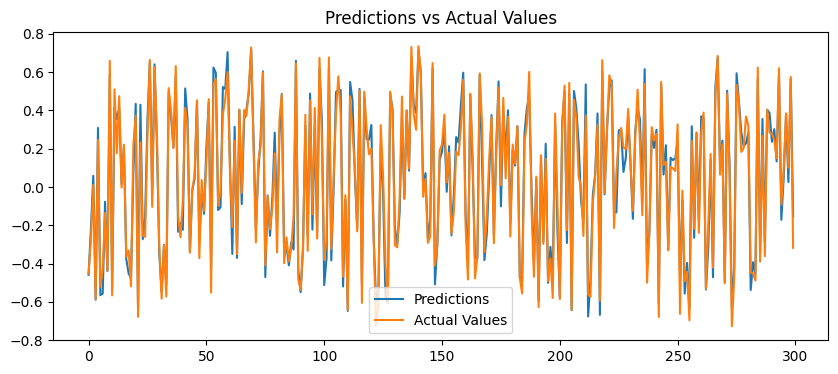

In [16]:
# You can plot the predictions vs actual values
plt.figure(figsize=(10, 4))
plt.title('Predictions vs Actual Values')
plt.plot(test_preds.numpy(), label='Predictions')
plt.plot(y_test.numpy(), label='Actual Values')
plt.legend()
plt.show()